In [ ]:
%pip install pandas==1.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
from datetime import datetime
import random
import bisect

In [ ]:
GiB32 = 32 * 1024 ** 3 # bytes in 32 GiB sector

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/df_supply_simulation_for_JP_Shyam_261122.csv")[2:]
dfu = df[['day_network_reward','day_locked_pledge','cum_network_reward', 'network_QAP', 'day_onboarded_power_QAP', 'day_renewed_power_QAP', 'date']]
dfu.loc[:,'zeroed_cum_network_reward'] = dfu.loc[:,'cum_network_reward']  - dfu.loc[2,'cum_network_reward']
dfu.loc[:,'zeroed_cum_network_reward_per32GiBQAP'] = GiB32 * (dfu.loc[:,'zeroed_cum_network_reward'] / (dfu.loc[:,'network_QAP']))
dfu.loc[:,'day_network_reward_per32GiBQAP'] =  GiB32 * dfu.loc[:,'day_network_reward'] / (dfu.loc[:,'network_QAP'])
dfu.loc[:,'day_penalty_per32GiBQAP'] = 90 * dfu.loc[:,'day_network_reward_per32GiBQAP']
dfu.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (dfu.loc[:,'day_locked_pledge'] / (dfu.loc[:,'network_QAP']))
dfu.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (dfu.loc[:,'day_locked_pledge'] / (dfu.loc[:,'day_onboarded_power_QAP']+dfu.loc[:,'day_renewed_power_QAP']))

Mounted at /content/drive


In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/df_supply_simulation_for_JP_Shyam_251122.csv")[2:]
dfu2 = df2[['day_network_reward','day_locked_pledge','cum_network_reward', 'network_QAP', 'day_onboarded_power_QAP', 'day_renewed_power_QAP', 'date']]
dfu2.loc[:,'zeroed_cum_network_reward'] = dfu.loc[:,'cum_network_reward']  - dfu.loc[2,'cum_network_reward']
dfu2.loc[:,'zeroed_cum_network_reward_per32GiBQAP'] = GiB32 * (dfu.loc[:,'zeroed_cum_network_reward'] / (dfu.loc[:,'network_QAP']))
dfu2.loc[:,'day_network_reward_per32GiBQAP'] =  GiB32 * dfu.loc[:,'day_network_reward'] / (dfu.loc[:,'network_QAP'])
dfu2.loc[:,'day_penalty_per32GiBQAP'] = 90 * dfu.loc[:,'day_network_reward_per32GiBQAP']
dfu2.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (dfu.loc[:,'day_locked_pledge'] / (dfu.loc[:,'network_QAP']))
dfu2.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (dfu.loc[:,'day_locked_pledge'] / (dfu.loc[:,'day_onboarded_power_QAP']+dfu.loc[:,'day_renewed_power_QAP']))

pledge_compute_df = dfu2[(dfu2['date']> '2022-07-01') & (dfu2['date']< '2022-11-01')] 
PLEDGE_ZERO_DAY = pledge_compute_df['day_locked_pledge_per32GiBQAP'].mean()
PLEDGE_ZERO_DAY 

0.238057284161032

In [ ]:
class ArrayWrapperObj:
    def __init__(self, arr):
        self.arr = arr
    def get(self):
        return self.arr

In [ ]:
dfv = pd.read_pickle("/content/drive/MyDrive/cil_mcmc_df_roi.pkl")
#  dfv = dfv.groupby('date').mean()
# dfv = dfv.groupby('date').median()

In [ ]:
def get_df_summary(df)->pd.DataFrame:
    df_summary = df.groupby(['date']).quantile([0.05,0.25,0.5,0.75,0.95]).reset_index(level=[0,1])
    df_summary.rename(columns = {'level_1':'quantile'}, inplace = True)
    return df_summary

In [ ]:
dfv_summary = get_df_summary(dfv)
dfv = dfv_summary[(dfv_summary['quantile'] == 0.5)]

<ipython-input-7-b1ff474fdfc2>:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_summary = df.groupby(['date']).quantile([0.05,0.25,0.5,0.75,0.95]).reset_index(level=[0,1])


In [ ]:
dfv.columns

Index(['date', 'quantile', 'days', 'circ_supply', 'network_gas_burn',
       'day_locked_pledge', 'day_renewed_pledge', 'network_locked_pledge',
       'network_locked', 'network_locked_reward', 'disbursed_reserve',
       'total_vest', 'network_RBP', 'network_QAP', 'day_onboarded_power_QAP',
       'day_renewed_power_QAP', 'cum_simple_reward', 'network_baseline',
       'capped_power', 'cum_capped_power', 'network_time',
       'cum_baseline_reward', 'cum_network_reward', 'day_network_reward',
       'iter', 'day_pledge_per_QAP', 'day_rewards_per_sector',
       '1y_return_per_sector', '1y_sector_roi'],
      dtype='object')

In [ ]:
dfu = dfv[['day_network_reward','day_locked_pledge','cum_network_reward', 'network_QAP', 'day_onboarded_power_QAP', 'day_renewed_power_QAP', 'day_pledge_per_QAP', 'date']][1:1830]
dfu = dfu.reset_index()
dfu.loc[:,'zeroed_cum_network_reward'] = dfu.loc[:,'cum_network_reward']  - dfu.loc[1,'cum_network_reward']
dfu.loc[:,'zeroed_cum_network_reward_per32GiBQAP'] = GiB32 * (dfu.loc[:,'zeroed_cum_network_reward'] / (dfu.loc[:,'network_QAP']))
dfu.loc[:,'day_network_reward_per32GiBQAP'] =  GiB32 * dfu.loc[:,'day_network_reward'] / (dfu.loc[:,'network_QAP'])
dfu.loc[:,'day_penalty_per32GiBQAP'] = 90 * dfu.loc[:,'day_network_reward_per32GiBQAP']
dfu.loc[:,'day_locked_pledge_per32GiBQAP'] = (dfu.loc[:,'day_pledge_per_QAP'])
# dfu.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (dfu.loc[:,'day_locked_pledge'] / (dfu.loc[:,'day_onboarded_power_QAP']+dfu.loc[:,'day_renewed_power_QAP']))

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import random

In [ ]:
GiB32 = 32 * 1024 ** 3 # bytes in 32 GiB sector

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/df_supply_simulation_for_JP_Shyam.csv")
dfu = df[['day_network_reward','day_locked_pledge','cum_network_reward', 'network_QAP', 'day_onboarded_power_QAP', 'day_renewed_power_QAP', 'date']]
dfu.loc[:,'zeroed_cum_network_reward'] = dfu.loc[:,'cum_network_reward']  - dfu.loc[2,'cum_network_reward']
dfu.loc[:,'zeroed_cum_network_reward_per32GiBQAP'] = GiB32 * (dfu.loc[:,'zeroed_cum_network_reward'] / (dfu.loc[:,'network_QAP']))
dfu.loc[:,'day_network_reward_per32GiBQAP'] =  GiB32 * dfu.loc[:,'day_network_reward'] / (dfu.loc[:,'network_QAP'])
dfu.loc[:,'day_penalty_per32GiBQAP'] = 90 * dfu.loc[:,'day_network_reward_per32GiBQAP']
dfu.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (dfu.loc[:,'day_locked_pledge'] / (dfu.loc[:,'network_QAP']))
dfu.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (dfu.loc[:,'day_locked_pledge'] / (dfu.loc[:,'day_onboarded_power_QAP']+dfu.loc[:,'day_renewed_power_QAP']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def p_gas(lambda_gas:float,reseal_day:int)->float:
    normal_gas = (365 * dfu.loc[reseal_day,'day_network_reward_per32GiBQAP'] / 10)
    gas_penalty = normal_gas * (1 + 365 * lambda_gas / reseal_day)
    return gas_penalty

def fraction_penalised(lambda_machine:float,reseal_day:int)->float:
    return np.exp(-reseal_day / (lambda_machine * 365))
    
def p_machine(lambda_machine:float,reseal_day:int,days_penalty:int)->float:
    penalty = (days_penalty / 90) * dfu.loc[reseal_day,'day_penalty_per32GiBQAP']
    time_distribution = fraction_penalised(lambda_machine,reseal_day)
    machine_penalty = penalty * time_distribution
    return machine_penalty

# utility of resealing
def u1_reseal(tau:int,T:int,lambda_gas=0.5,lambda_machine=0.5,days_penalty=90,debug=False)->float:
    '''
    -----------------------
    tau : int
        time until reseal required
    T : int 
        time left in sector duration commitment
    lambda_gas : float:
        Strength of block space constraint
    lambda_machine : float 
        Strength of sealing machine availabilty
    
    '''
    if tau>T:
        reseal_day = np.round(T * 0.8)
    else:
        reseal_day = np.round(tau * 0.8) # typical reseal is 80% of max
    
    cum_reward = dfu.loc[T,'zeroed_cum_network_reward_per32GiBQAP']
    pledge = dfu.loc[reseal_day,'day_locked_pledge_per32GiBQAP']
    pledge_return = PLEDGE_ZERO_DAY 
    extra_pledge = max(pledge - pledge_return,0)
    gas = p_gas(lambda_gas,reseal_day)
    machine = p_machine(lambda_machine,reseal_day,days_penalty)
    utility = cum_reward - extra_pledge - gas - machine
    
    if debug == True:
        print(np.round([utility, cum_reward, pledge,pledge_return, extra_pledge, gas, machine],2))
    else:
        return utility
    
# utility of not resealing
def u2_noreseal(tau:int,T:int,days_penalty:int,debug=False)->float:
    ''' 
    '''
    reward_horizon = min(tau, T)
    reward = dfu.loc[reward_horizon,'zeroed_cum_network_reward_per32GiBQAP'] 
    penalty = (days_penalty / 90) * dfu.loc[tau,'day_penalty_per32GiBQAP'] if tau<T else 0
    utility = reward - penalty
    
    if debug == True:
        print(np.round([utility, reward, penalty, reward_horizon],4))
    else:
        return utility
    
def find_optimal_reseal_time(lambda_gas:float, lambda_machine:float, T)->float:
    u1_reseals = [u1_reseal(tau, T, lambda_gas, lambda_machine) for tau in taulist]
    u2_noreseals = [u2_noreseal(tau, T) for tau in taulist]
    return taulist[np.argmax(np.array(u1_reseals) - np.array(u2_noreseals))]

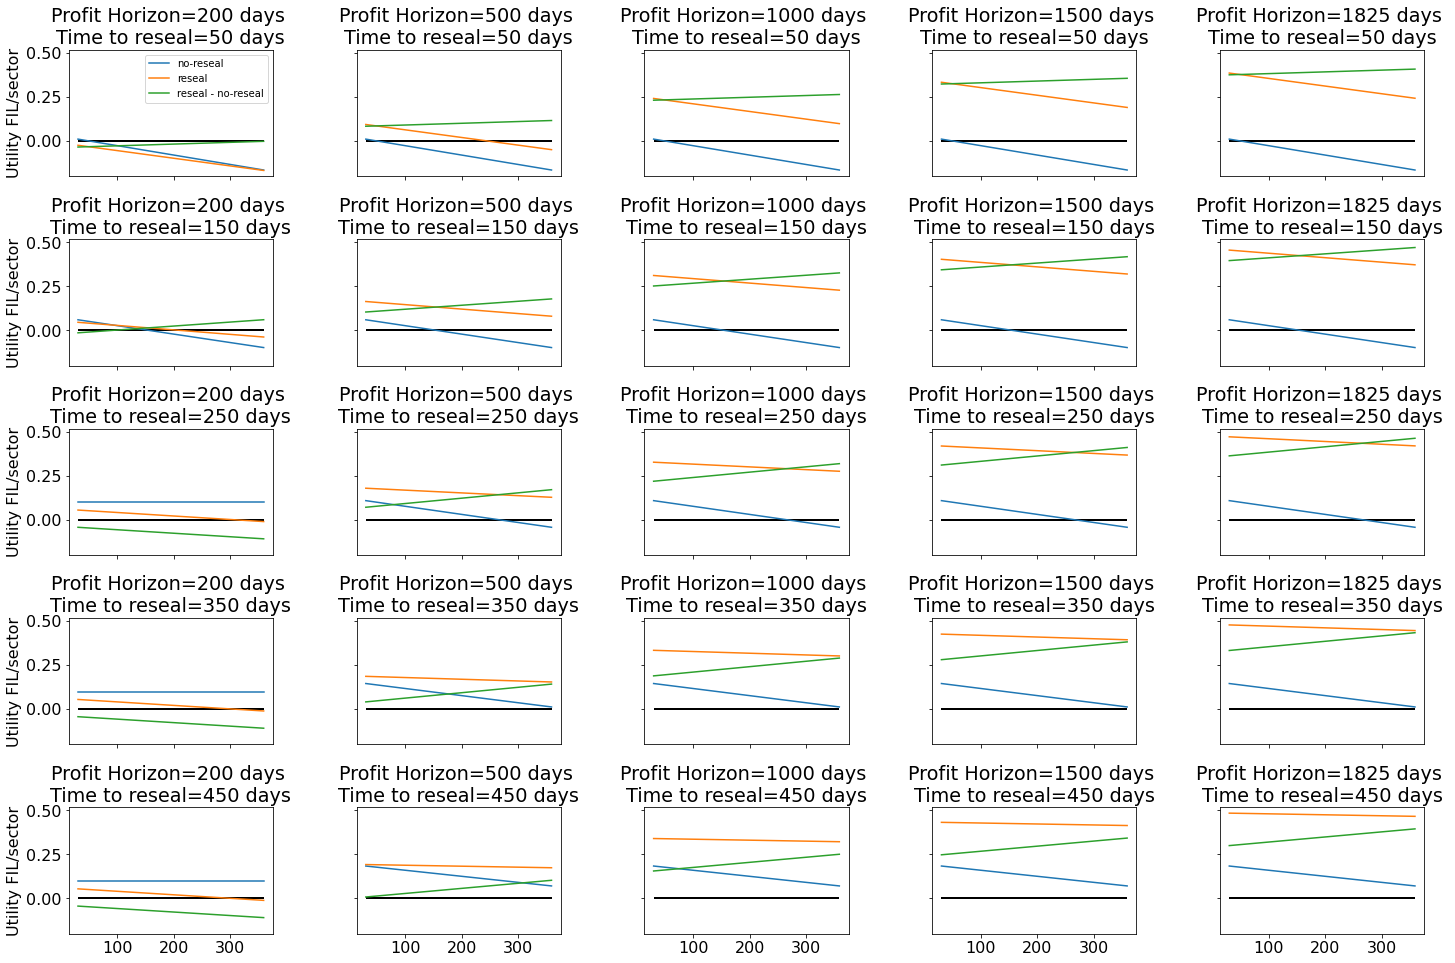

In [ ]:
taulist, tlist, daypenaltylist = np.arange(30,500), np.arange(30,1000), np.arange(30,360)

time_to_reseals = [50,150,250,350,450]
sec_dur_remains = [200,500,1000, 1500, 1825]

fig, axes = plt.subplots(nrows=len(time_to_reseals), 
                         ncols=len(sec_dur_remains), 
                         figsize=(21,14), 
                         sharex=True, sharey=True)
fig.tight_layout(pad=3.0)
for si, s_i in enumerate(sec_dur_remains): #time remaining in sector duration
    for taui, tau_i in enumerate(time_to_reseals): #time to reseal
        ax = axes[taui,si]
        ax.plot(daypenaltylist,
                [u2_noreseal(tau_i,s_i,day_penalty) 
                 for day_penalty in daypenaltylist], label='no-reseal');
        ax.plot(daypenaltylist,
                [u1_reseal(tau_i,s_i,0.5,0.5,day_penalty) 
                 for day_penalty in daypenaltylist], label='reseal');
        ax.plot(daypenaltylist,
                [u1_reseal(tau_i,s_i,0.5,0.5,day_penalty) - u2_noreseal(tau_i,s_i,day_penalty) 
                 for day_penalty in daypenaltylist], 
             label='reseal - no-reseal');
        ax.hlines(y=0, xmin=daypenaltylist[0], xmax=daypenaltylist[-1], linewidth=2, color='black')
        if (taui == 0) and (si == 0):
            ax.legend()
        ax.set_title(f"Profit Horizon={s_i} days \nTime to reseal={tau_i} days")
        
        
        if (si == 0):
            ax.set_ylabel('Utility FIL/sector')

        if taui == len(sec_dur_remains):
            ax.set_xlabel('Penalty (days-worth-of-rewards)')

In [ ]:
!pip install python-ternary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
time_to_reseals = [50,150,250,350,450,550]
sec_dur_remains = [200,500,1000,1500,1825]
day_penalty_list = np.arange(30,360)

Tau, t, D = np.meshgrid(time_to_reseals, sec_dur_remains, day_penalty_list)

In [ ]:
Z1 = []
Z2 = []
for T in sec_dur_remains:
    for tau in time_to_reseals:
        for days in daypenaltylist:
            Z1.append(u1_reseal(tau,T=T,lambda_gas=0.5,lambda_machine=0.5,days_penalty=days))
            Z2.append(u2_noreseal(tau,T=T,days_penalty=days))

Z3 = (np.array(Z1)-np.array(Z2))

NT = np.product(Tau.shape)

data = {
    "Tau": np.reshape(Tau,NT),
    "t": np.reshape(t,NT),
    "D": np.reshape(D,NT),
    "U(Reseal)": Z1,
    "U(NoReseal)": Z2,
    "U(Reseal) - U(NoReseal)": Z3
    
}

df = pd.DataFrame(data=data)

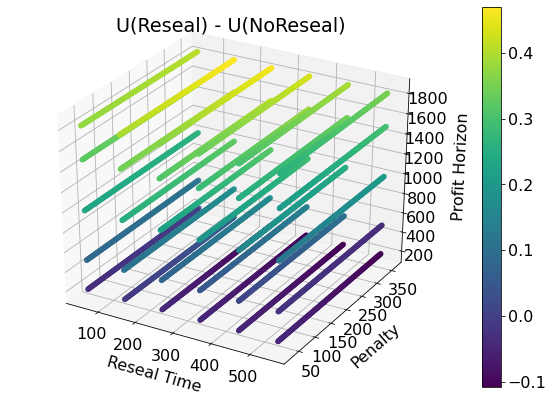

In [ ]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')


img = ax.scatter(Tau, D, t, c=Z3, cmap = plt.viridis())
fig.colorbar(img)
plt.title('U(Reseal) - U(NoReseal)')

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 15
ax.set_xlabel('Reseal Time')
ax.set_ylabel('Penalty')
ax.set_zlabel('Profit Horizon');
plt.show()

In [ ]:
plot_list = []

for sd in sec_dur_remains:
  Z1 = [[u1_reseal(tau,T=sd,lambda_gas=0.5,lambda_machine=0.5,days_penalty=days)
       for tau in time_to_reseals]
      for days in day_penalty_list]
  Z2 = [[u2_noreseal(tau,T=sd,days_penalty=days)
       for tau in time_to_reseals]
      for days in day_penalty_list]

  Z3 = (np.array(Z1)-np.array(Z2))

  plot_list.append(Z3)

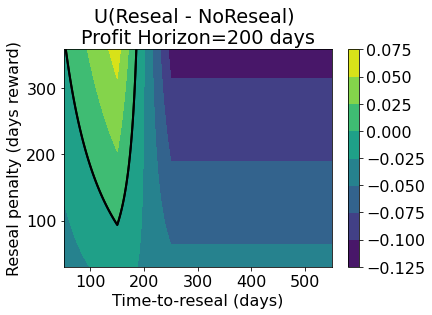

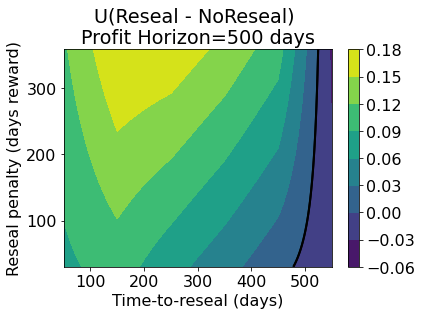

<ipython-input-20-5c233558ae21>:4: UserWarning: No contour levels were found within the data range.
  cp1_0 = plt.contour(time_to_reseals, day_penalty_list, plot_list[i],levels = [-0.0001,0],


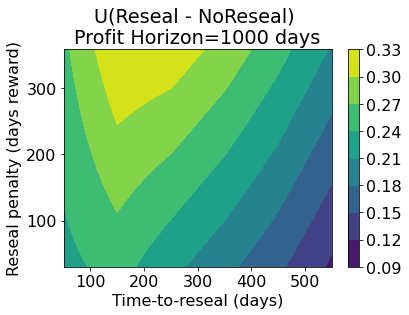

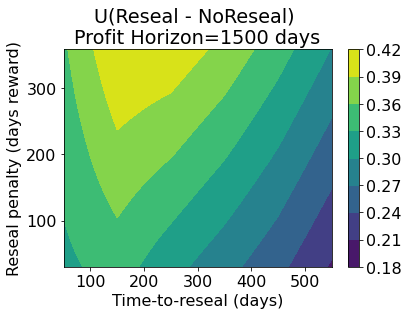

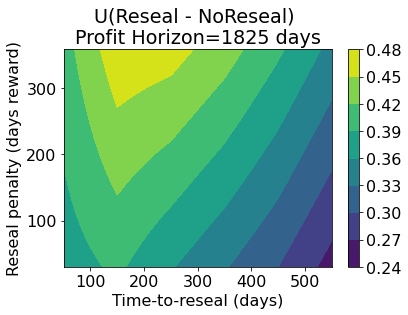

In [ ]:
for i in range(len(plot_list)):
  fig,ax = plt.subplots(1,1)
  cp1 = ax.contourf(time_to_reseals, day_penalty_list, plot_list[i])
  cp1_0 = plt.contour(time_to_reseals, day_penalty_list, plot_list[i],levels = [-0.0001,0],
                 colors=('k',),linestyles=('-',),linewidths=(2,))
  fig.colorbar(cp1) 
  ax.set_title(f'U(Reseal - NoReseal) \nProfit Horizon={sec_dur_remains[i]} days')
  ax.set_ylabel('Reseal penalty (days reward)')
  ax.set_xlabel('Time-to-reseal (days)')
  plt.show()

In [ ]:
df.head(5)

,Tau,t,D,U(Reseal),U(NoReseal),U(Reseal) - U(NoReseal)
0,50,200,30,-0.024971,0.009962,-0.034932
1,50,200,31,-0.025405,0.009429,-0.034834
2,50,200,32,-0.025839,0.008896,-0.034735
3,50,200,33,-0.026274,0.008363,-0.034637
4,50,200,34,-0.026708,0.007830,-0.034538


In [ ]:
import plotly
import plotly.graph_objs as go

def makeAxis(title, tickangle):
    return {
      'title': title,
      'titlefont': { 'size': 20 },
      'tickangle': tickangle,
      'tickfont': { 'size': 15 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

fig1 = px.scatter_ternary(df, a = 'Tau', b = 't', c = 'D', color = "U(Reseal)")
fig1.update_layout({
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Reseal Time', 0),
        'baxis': makeAxis('<br>Profit Horizon', 45),
        'caxis': makeAxis('<br>Penalty', -45)
    },

})
fig1.show()

In [ ]:
import plotly
import plotly.graph_objs as go


def makeAxis(title, tickangle):
    return {
      'title': title,
      'titlefont': { 'size': 20 },
      'tickangle': tickangle,
      'tickfont': { 'size': 15 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

fig1 = px.scatter_ternary(df, a = 'Tau', b = 't', c = 'D', color = "U(NoReseal)")
fig1.update_layout({
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Reseal Time', 0),
        'baxis': makeAxis('<br>Profit Horizon', 45),
        'caxis': makeAxis('<br>Penalty', -45)
    },

})
fig1.show()

In [ ]:
import plotly
import plotly.graph_objs as go

def makeAxis(title, tickangle):
    return {
      'title': title,
      'titlefont': { 'size': 20 },
      'tickangle': tickangle,
      'tickfont': { 'size': 15 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

fig1 = px.scatter_ternary(df, a = 'Tau', b = 't', c = 'D', color = "U(Reseal) - U(NoReseal)")
fig1.update_layout({
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Reseal Time', 0),
        'baxis': makeAxis('<br>Profit Horizon', 45),
        'caxis': makeAxis('<br>Penalty', -45)
    },

})
fig1.show()

In [ ]:
!pip install samternary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from mlxtend.preprocessing import minmax_scaling

test_data = df

a = minmax_scaling(df, columns=['Tau']).values.flatten()
b = minmax_scaling(df, columns=['t']).values.flatten()
c = minmax_scaling(df, columns=['D']).values.flatten()

v = np.array(test_data[test_data.columns[3]]).flatten()

9900
9900


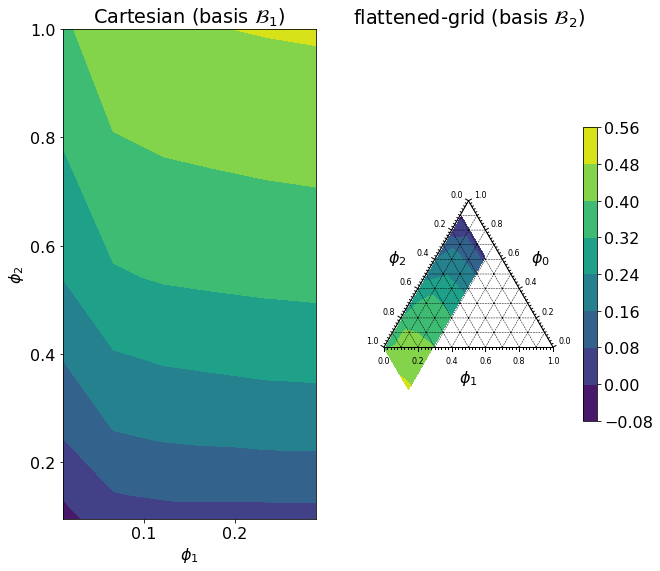

In [ ]:
import matplotlib.tri as tri
from samternary.ternary import Ternary

df2 = df[['Tau','t','D']]

df_norm = (df2-min(df2.min()))/(max(df2.max())-min(df2.min()))

test_data = df_norm

a=test_data[test_data.columns[0]]
b=test_data[test_data.columns[1]]
c=test_data[test_data.columns[2]]

# values is stored in the last column
v=df[df.columns[3]]

# translate the data to cartesian corrds
# x = 0.5 * ( 2.*b+c ) / ( a+b+c )
# y = 0.5*np.sqrt(3) * c / (a+b+c)

# A = x
# B = y
# C = 1 - (x + y)
# D = v

A = a
print(len(A))
B = b
print(len(B))
#C = 1 - (x + y)
D = v

# plot the data in two ways, in cartesian coordinates (ax_norm)         
# and in ternary-plot coordinates (ax_trans)                            

# create the figure and the two sets of axes                            
fig, (ax_norm,ax_trans) = plt.subplots(1,2,
                                       figsize=[10,10])


# plot data in normal way first using tricontourf                       
ax_norm.tricontourf(A,B,D)
ax_norm.set_xlabel(r'$\phi_1$')
ax_norm.set_ylabel(r'$\phi_2$')

# transform ax_trans to ternary-plot style, which includes              
# building axes and labeling the axes                                   
cob = Ternary(ax_trans, bottom_ax = 'bottom', left_ax = 'left',
              right_ax = 'right',labelpad=20)

# use change of bases method within Ternary() to                        
points = cob.B1_to_B2(A,B)

# affine transform x,y points to ternary-plot basis                     
cs = ax_trans.tricontourf(points[0],points[1],D)


ax_norm.set_title("Cartesian "
                  "(basis " + r"$\mathcal{B}_1$" + ")")
ax_trans.set_title("flattened-grid "
                   "(basis " + r"$\mathcal{B}_2$" + ")")

cbar = fig.colorbar(cs,ax=ax_trans,shrink=0.6)
fig.subplots_adjust(bottom=0.2,hspace=0.01)
plt.show()

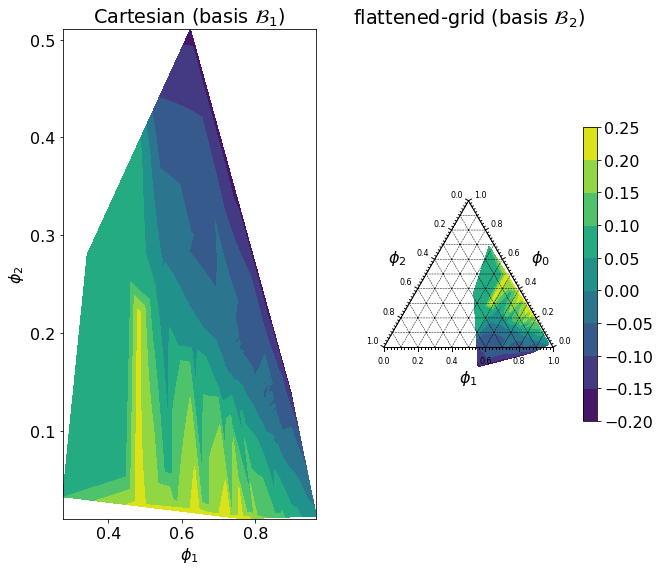

In [ ]:
# values is stored in the last column

test_data = df

a=test_data[test_data.columns[0]]
b=test_data[test_data.columns[1]]
c=test_data[test_data.columns[2]]
v=test_data[test_data.columns[4]]

# translate the data to cartesian corrds
x = 0.5 * (2.*b+c) / (a+b+c)
y = 0.5 * np.sqrt(3) * c / (a+b+c)


A = x
B = y
#C = 1 - (x + y)
D = v

# plot the data in two ways, in cartesian coordinates (ax_norm)         
# and in ternary-plot coordinates (ax_trans)                            

# create the figure and the two sets of axes                            
fig, (ax_norm,ax_trans) = plt.subplots(1,2,
                                       figsize=[10,10])


# plot data in normal way first using tricontourf                       
ax_norm.tricontourf(A,B,D)
ax_norm.set_xlabel(r'$\phi_1$')
ax_norm.set_ylabel(r'$\phi_2$')

# transform ax_trans to ternary-plot style, which includes              
# building axes and labeling the axes                                   
cob = Ternary(ax_trans, bottom_ax = 'bottom', left_ax = 'left',
              right_ax = 'right',labelpad=20)

# use change of bases method within Ternary() to                        
points = cob.B1_to_B2(A,B)

# affine transform x,y points to ternary-plot basis                     
cs = ax_trans.tricontourf(points[0],points[1],D)


ax_norm.set_title("Cartesian "
                  "(basis " + r"$\mathcal{B}_1$" + ")")
ax_trans.set_title("flattened-grid "
                   "(basis " + r"$\mathcal{B}_2$" + ")")

cbar = fig.colorbar(cs,ax=ax_trans,shrink=0.6)
fig.subplots_adjust(bottom=0.2,hspace=0.01)
plt.show()

## `ProofRefreshWindow` tuning for different termination fees

In [ ]:
def time_to_reseal(ProofRefreshWindow, number_of_refreshes, beta_value, MaxProofDuration = 540):
  ProofExpiry = (number_of_refreshes + 1)*MaxProofDuration - (number_of_refreshes)*ProofRefreshWindow
  ProofRefreshStart = (number_of_refreshes + 1)*MaxProofDuration - (number_of_refreshes + 1)*ProofRefreshWindow

  if number_of_refreshes == 0:
    ProofLastRefreshed = 0
  else:
    lower_bound = (number_of_refreshes)*MaxProofDuration - (number_of_refreshes)*ProofRefreshWindow
    upper_bound = (number_of_refreshes)*MaxProofDuration - (number_of_refreshes - 1)*ProofRefreshWindow

    X = np.random.beta(beta_value,1)
    ProofLastRefreshed = (ProofRefreshWindow)*X + lower_bound

  if number_of_refreshes == 5:
    BugDiscovered = np.random.uniform(low = ProofLastRefreshed, high = 1825)
    TimeToResealStart = BugDiscovered
    ProofExpiry = 1825
    reseal_time = ProofExpiry - TimeToResealStart

  else:
    BugDiscovered = np.random.uniform(low = ProofLastRefreshed, high = ProofExpiry)
    if ProofRefreshStart < BugDiscovered < ProofExpiry:
        delta = random.randint(0,min(int(ProofExpiry - BugDiscovered),7))
        TimeToResealStart = BugDiscovered + delta
        ProofExpiry = (number_of_refreshes + 2)*MaxProofDuration - (number_of_refreshes + 1)*ProofRefreshWindow
    else:
      TimeToResealStart = BugDiscovered
    reseal_time = ProofExpiry - TimeToResealStart


  return reseal_time

In [ ]:
def generate_num_refreshes(ProofRefreshWindow, MaxProofDuration = 540):
  if (4*MaxProofDuration - 3*ProofRefreshWindow) >= 1825:
    random_number = np.random.uniform(low = 0, high = 100)

    if random_number <= 50:
      return 0
    elif (random_number > 50) and  (random_number <= 75):
      return 1
    elif (random_number > 75) and  (random_number <= 90):
      return 2
    else:
      return 3

  else:
    random_number = np.random.uniform(low = 0, high = 100)

    if random_number <= 45:
      return 0
    elif (random_number > 45) and  (random_number <= 70):
      return 1
    elif (random_number > 70) and  (random_number <= 85):
      return 2
    elif (random_number > 85) and  (random_number <= 90):
      return 3
    else:
      return 4

In [ ]:
df = pd.DataFrame()
df_i = pd.DataFrame({'Reseal Time':[], 'ProofRefreshWindow':[]})
days = [0,10,30,60,100,120,175,225]

for day in days:
  plot_list = [time_to_reseal(day, generate_num_refreshes(day),1) for i in range(100000)]
  df_i['Reseal Time'] = plot_list
  df_i['ProofRefreshWindow'] = str(day)
  df = df.append(df_i)

<ipython-input-31-6d1944558d71>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-31-6d1944558d71>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-31-6d1944558d71>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-31-6d1944558d71>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-31-6d1944558d71>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-31-6d1944558d71>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

### 100 days

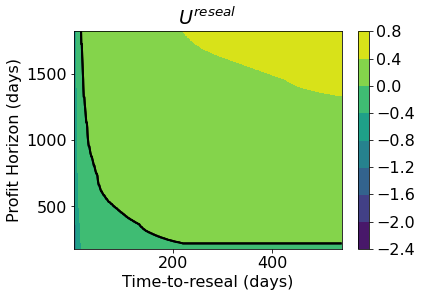

In [ ]:
taulist, tlist = np.arange(2,540), np.arange(180,1825)
Tau, T = np.meshgrid(taulist, tlist)
Z1 = [[u1_reseal(tau=tau,T=T,lambda_gas=0.5,lambda_machine=0.5,days_penalty=400) for tau in taulist] for T in tlist]

fig,ax = plt.subplots(1,1)
cp = ax.contourf(Tau, T, Z1)
cp0 = plt.contour(Tau, T, Z1,levels = [-0.0001,0],
                 colors=('k',),linestyles=('-',),linewidths=(2,))
fig.colorbar(cp) 
ax.set_title('${U^{reseal}}$')
ax.set_ylabel('Profit Horizon (days)')
ax.set_xlabel('Time-to-reseal (days)')
plt.show()

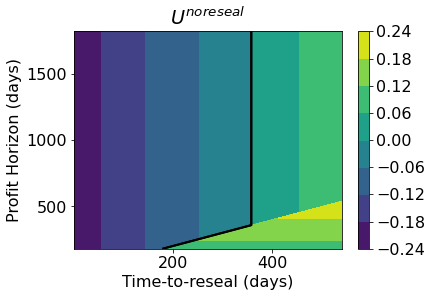

In [ ]:
Z2 = [[u2_noreseal(tau=tau,T=T,days_penalty=400) for tau in taulist] for T in tlist]

fig,ax = plt.subplots(1,1)
cp = ax.contourf(Tau, T, Z2)
cp0 = plt.contour(Tau, T, Z2,levels = [-0.0001,0],
                 colors=('k',),linestyles=('-',),linewidths=(2,))
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('$U^{no reseal}}$')
ax.set_ylabel('Profit Horizon (days)')
ax.set_xlabel('Time-to-reseal (days)')
plt.show()

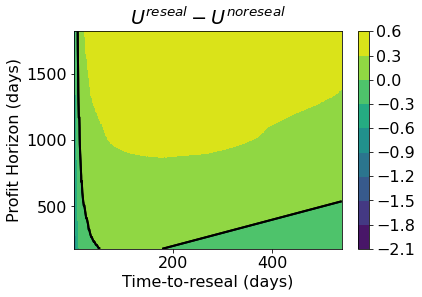

In [ ]:
Z3 = (np.array(Z1)-np.array(Z2))
fig,ax = plt.subplots(1,1)
cp = ax.contourf(Tau, T, Z3)
cp0 = plt.contour(Tau, T, Z3,levels = [-0.0001,0],
                 colors=('k',),linestyles=('-',),linewidths=(2,))

fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('${U^{reseal} - U^{no reseal}}$')
ax.set_ylabel('Profit Horizon (days)')
ax.set_xlabel('Time-to-reseal (days)')
plt.show()

In [ ]:
p = cp0.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]

In [ ]:
min(x)

179.33100588553904

In [ ]:
rel_utility = {}
for A, B in zip(x, y):
    rel_utility[A] = B

In [ ]:
p = cp0.collections[0].get_paths()[1]
v = p.vertices
x = v[:,0]
y = v[:,1]

In [ ]:
max(x)

54.12173229829626

In [ ]:
for A, B in zip(x, y):
    rel_utility[A] = B

In [ ]:
for i in range(55,179):
  rel_utility[i] = 0

In [ ]:
def rel_utility_mapping(a):
  res = min(rel_utility.keys(), key = lambda key: abs(key-a))
  return rel_utility[res]

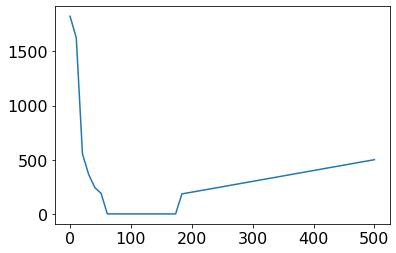

In [ ]:
plt.plot(np.linspace(0,500), [rel_utility_mapping(reseal_day_i) for reseal_day_i in np.linspace(0,500)])

In [ ]:
days = ['0','10','30','60','100','120','175','225']
breakeven_dict = {}

for day in days:
  df_temp = df.loc[df['ProofRefreshWindow'] == day]
  distribution_list = []
  for i in df_temp['Reseal Time']:
    distribution_list.append(rel_utility_mapping(i))

  breakeven_dict[day] = distribution_list

breakeven_df = pd.DataFrame(breakeven_dict.items(), columns=['ProofRefreshWindow', 'Breakeven Point'])

In [ ]:
quantiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]
for quantile in quantiles:
  temp = []
  for i in breakeven_df['Breakeven Point']:
    temp.append(np.quantile(np.array(i),quantile))
  
  breakeven_df[str(quantile)] = temp

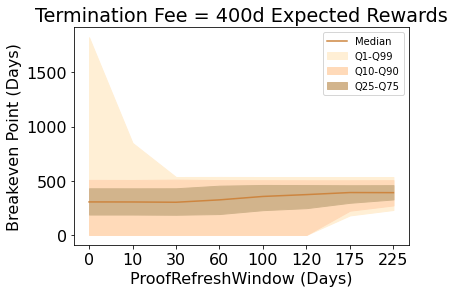

In [ ]:
import seaborn as sns

#colors = {'3':'green', '4':'blue'}
#plt.scatter(breakeven_df['ProofRefreshWindow'], breakeven_df['E[Breakeven Point]'], c = breakeven_df['Number of Refreshes'].map(colors))
# for index,i in breakeven_df.iterrows():

#     label = "{}".format(i['Number of Refreshes'])

#     plt.annotate(label, # this is the text
#                  (i['ProofRefreshWindow'],i['E[Breakeven Point]']), # these are the coordinates to position the label
#                  textcoords="offset pixels", # how to position the text
#                  xytext=(0,5),
#                  ha='right')

# sns.lineplot(x = breakeven_df['ProofRefreshWindow'], y = breakeven_df['0.05'])
# sns.scatterplot(x = 'ProofRefreshWindow', y = '0.05', data=breakeven_df, hue='Number of Refreshes', palette=['green','dodgerblue'], legend='full', s=100)

# breakeven_df.plot(x="ProofRefreshWindow", y=['0.05','0.25','0.5','0.75','0.95'], marker='o')
plt.fill_between(breakeven_df['ProofRefreshWindow'], breakeven_df['0.01'], breakeven_df['0.99'], 
                     alpha=1, color='papayawhip', label='Q1-Q99')
plt.fill_between(breakeven_df['ProofRefreshWindow'], breakeven_df['0.1'], breakeven_df['0.9'], 
                     alpha=1, color='peachpuff', label='Q10-Q90')
# plt.fill_between(breakeven_df['ProofRefreshWindow'], breakeven_df['0.05'], breakeven_df['0.95'], 
#                      alpha=0.55, color='moccasin', label='Q5-Q95')
plt.fill_between(breakeven_df['ProofRefreshWindow'], breakeven_df['0.25'], breakeven_df['0.75'], 
                     alpha=1, color='tan', label='Q25-Q75')
plt.plot(breakeven_df['ProofRefreshWindow'], breakeven_df['0.5'],
                     alpha=1, color='peru', label='Median')
plt.xlabel('ProofRefreshWindow (Days)')
plt.ylabel("Breakeven Point (Days)");
plt.title("Termination Fee = 400d Expected Rewards")
plt.legend()
plt.show()  

### 200 days

### 300 *days*

### 400 days